In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torch
import torch.nn.functional as F
import pandas as pd
import torchvision
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchmetrics.classification import MulticlassConfusionMatrix, F1Score, MulticlassPrecision, MulticlassRecall, MulticlassPrecisionRecallCurve, MulticlassROC
from torch.optim import lr_scheduler
import torch.nn as nn
import torch
import pytorch_lightning as pl
from torch.utils.tensorboard import SummaryWriter
from matplotlib.backends.backend_agg import FigureCanvasAgg

import confinement_mode_classifier as cmc
import alt_models as am


In [2]:
signal_window = 320
num_workers = 6
signal_name = 'mc'
batch_size = 512
pl.seed_everything(42)
path=os.getcwd()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
shot_usage = pd.read_csv(f'{path}/data/shot_usage.csv')
shot_for_ris = shot_usage[shot_usage['used_for_alt']]
shot_numbers = shot_for_ris['shot']
shots_for_testing = shot_for_ris[shot_for_ris['used_as'] == 'test']['shot']
shots_for_validation = shot_for_ris[shot_for_ris['used_as'] == 'val']['shot']


Seed set to 42


In [3]:
from importlib import reload
reload(am)

<module 'alt_models' from '/compass/Shared/Users/bogdanov/vyzkumny_ukol/alt_models.py'>

In [10]:

shot_df, test_df, val_df, train_df = am.split_df(path, shot_numbers, shots_for_testing, shots_for_validation, use_ELMS=True, signal_name=signal_name)


# Create dataloaders
train_dataloader = am.get_dloader(train_df, batch_size=batch_size, 
                            balance_data=True, shuffle=False, 
                            signal_window=signal_window,
                            signal_name=signal_name,
                            num_workers=num_workers)

val_dataloader = am.get_dloader(val_df, batch_size=batch_size, 
                            balance_data=True, shuffle=False, 
                            signal_window=signal_window,
                            signal_name=signal_name,
                            num_workers=num_workers)

test_dataloader = am.get_dloader(test_df, batch_size=batch_size, 
                            balance_data=False, shuffle=False, 
                            signal_window=signal_window,
                            signal_name=signal_name,
                            num_workers=num_workers)

In [13]:
model = am.select_model_architecture('InceptionTime', num_classes=3, window=320)
model.load_state_dict(torch.load(f'/compass/Shared/Users/bogdanov/vyzkumny_ukol/runs/24-02-22, 18-31-57 InceptionTime_on_Mink_coil_320dpoints_16_epochs/model.pt'))
model.eval()

model.to(device)

Sequential(
  (0): Reshape()
  (1): InceptionBlock(
    (activation): ReLU()
    (inception_1): Inception(
      (conv_from_bottleneck_1): Conv1d(1, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (conv_from_bottleneck_2): Conv1d(1, 32, kernel_size=(11,), stride=(1,), padding=(5,), bias=False)
      (conv_from_bottleneck_3): Conv1d(1, 32, kernel_size=(23,), stride=(1,), padding=(11,), bias=False)
      (max_pool): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
      (conv_from_maxpool): Conv1d(1, 32, kernel_size=(1,), stride=(1,), bias=False)
      (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (inception_2): Inception(
      (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,), bias=False)
      (conv_from_bottleneck_1): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (conv_from_bottleneck_2): Conv1d(32, 32, kernel_siz

In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=200, weight_decay=0.01)
exp_lr_scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, total_steps=24) #!!!
learning_rates = []
for i in range(24):
    a = model(next(iter(train_dataloader))[signal_name].to(device).float())
    optimizer.step()
    exp_lr_scheduler.step()
    learning_rates.append(exp_lr_scheduler.get_last_lr())

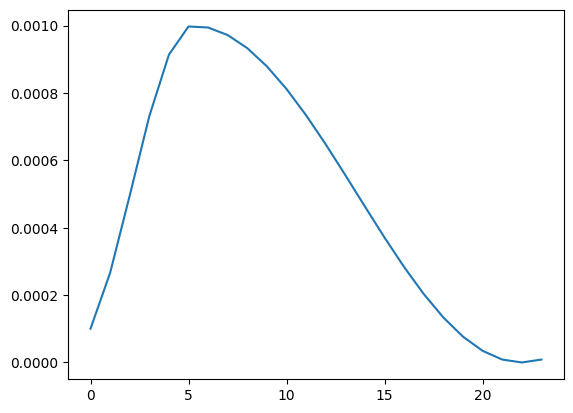

In [16]:
import matplotlib.pyplot as plt

plt.plot(learning_rates)

In [15]:
model(next(iter(train_dataloader))[signal_name].to(device).float()).shape

torch.Size([512, 3])

In [2]:
import os
from pathlib import Path
import sys
# sys.path.append('/compass/Shared/Common/IT/projects/user-libraries/python/cdb_extras/stable/cdb_extras')
# import xarray_support as cdbxr   # načítání dat z databáze COMPASSu
from cdb_extras import xarray_support as cdbxr   # načítání dat z databáze COMPASSu
from pyCDB import client
import pandas as pd
import xrscipy.signal as dsp
import numpy as np
from tqdm import tqdm

os.chdir('/compass/Shared/Users/bogdanov/vyzkumny_ukol')
import imgs_processing as imgs

cdb = client.CDBClient()
shot_from_client = cdbxr.Shot(16989)
        
# Load signals from CDBClient
mcHFS_signal = shot_from_client['Mirnov_coil_A_theta_13_RAW']
mcLFS_signal = shot_from_client['Mirnov_coil_A_theta_01_RAW']
mcDIV_signal = shot_from_client['Mirnov_coil_A_theta_19_RAW']
mcTOP_signal = shot_from_client['Mirnov_coil_A_theta_07_RAW']

In [26]:
scaler = imgs.RobustScalerNumpy().fit_transform

In [30]:
mcHFS_signal, mcLFS_signal, mcDIV_signal, mcTOP_signal = map(lambda signal: scaler(dsp.decimate(signal, target_fs=300)),
                                                             [mcHFS_signal, mcLFS_signal, mcDIV_signal, mcTOP_signal])



In [ ]:
scaler = imgs.RobustScalerNumpy().fit_transform
signal = dsp.decimate(signal, target_fs=300) 
signal = scaler(signal)